# Making Faces with Generative Adversarial Networks
![](https://raw.githubusercontent.com/NVlabs/stylegan/master/stylegan-teaser.png)

Many **face recognition systems are biased** based on gender and ethnicity: for example, they are far more accurate for light-skinned men than dark-skinned women. Check out the video at http://gendershades.org/ for a great explanation.

One reason for this issue is that training datasets disproportionately include photos of light-skinned men. To make systems less biased, we need to train our systems using more diverse datasets. What if we can't find diverse photo datasets? **Maybe we can use diverse computer-generated images instead.**

**In this notebook, we will train a GAN to generate faces**. We'll be making very small images for now: generating super-realistic photos like the ones above requires a lot of time, processing power, and research to find the best network architecture. You can experiment with increasing the image size.

In [2]:
#@title Run this to load some packages and data! It might take a couple of minutes. { display-mode: "form" }
import tensorflow as tf
!pip install imageio
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow_datasets as tfds
from mpl_toolkits.axes_grid1 import ImageGrid
from itertools import islice
from IPython import display

ds_original, ds_info = tfds.load('lfw', split='train', shuffle_files=False, with_info = True) 

def show_dataset_examples(ds):
  grid = ImageGrid(plt.figure(), 111, nrows_ncols=(3, 3), axes_pad = 0.1)
  for index, img in islice(enumerate(ds_small),9):
    grid[index].imshow((img+1)/2)
  plt.show()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

def train(dataset, epochs):

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      scale_and_show(predictions[i])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show() 

# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteOQZ9GI/lfw-train.tfrecord


Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


### Prepare the dataset

We will use the [Labeled Faces in the Wild ](https://www.tensorflow.org/datasets/catalog/lfw)dataset to train the generator and the discriminator. 

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


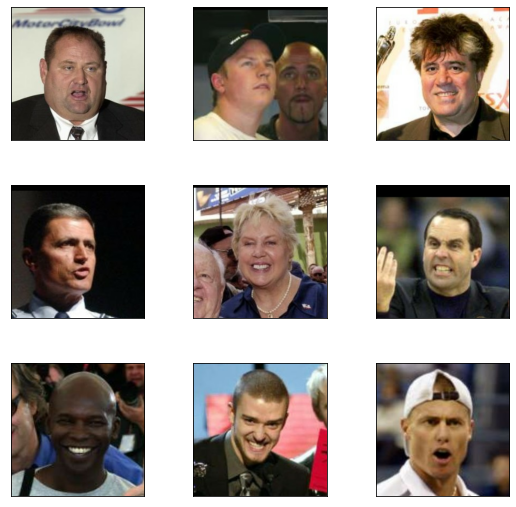

Dataset information:
{'train': <tfds.core.SplitInfo num_examples=13233>}
<PrefetchDataset shapes: {image: (250, 250, 3), label: ()}, types: {image: tf.uint8, label: tf.string}>


In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
IMG_SIZE = 28
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim]) # We will reuse this seed over time so it's easier to visualize progress in the animated GIF)
tfds.show_examples(ds_info, ds_original)

print("Dataset information:")
print(ds_info.splits)
print(ds_original)


### Exercise 1 ✍️

**Based on the information printed above,** what are the dimensions of each image in the dataset? How many images are there?

**Do you notice anything interesting** about the example images displayed?

To preprocess our data, we need to make two changes: 

1) Resize the images to 28 x 28 pixels (still 3 color channels), so that we can train our GAN quickly.

2) [Scale the data](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/) so that entries are in the range of -1 to 1 rather than 0 to 255, which usually makes training more efficient.

Replace the blanks in the function below to make both changes.

Resized dataset:


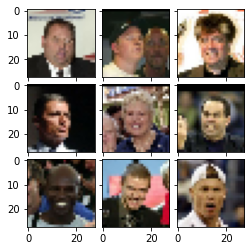

<BatchDataset shapes: (None, 28, 28, 3), types: tf.float32>


In [4]:
def preprocess(entry):
  img = tf.image.resize(entry['image'],[28,28])
  img = img / 127.5 - 1 
  return img

ds_small = ds_original.map(preprocess)

print ("Resized dataset:")
show_dataset_examples(ds_small)

train_dataset = ds_small.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)

## Create the models



### The Generator
In many CNNs, we want to go from a large-dimensional input (an image) to a small-dimensional output (like a classification).

In the generator, we want to go from a small-dimensional input (random noise) to a large-dimensional output (an image). We do this by using a `Dense` layer that takes the random noise as input, and then using `tf.keras.layers.Conv2DTranspose` (upsampling) layers several times until we reach the desired final image size. 

Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.





### Exercise 2 ✍️
Here is an illustration of an upsampling layer:

![](https://miro.medium.com/max/1400/1*faRskFzI7GtvNCLNeCN8cg.png)

**Can you explain how this layer works? How do we calculate the dimensions of the output? What about if there is a stride of size bigger than 1?**

The cell below shows the architecture of our generator. Fill in the blanks to use the correct [Conv2D parameters](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) and show the correct output shape at each stage.

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) 
    # The assert line shows the expected output shape at this stage. None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 3) #What is the desired output size for the whole generator? 

    return model

Use the (as yet untrained) generator to create an image. We can also see the model's output shape at each step - does it match what you expect?

tf.Tensor(
[[[[ 2.17063143e-03  1.37943705e-03  2.70822761e-03]
   [-3.76082957e-03 -7.13789696e-03  7.52327032e-04]
   [ 2.29579047e-03 -2.72379536e-03  5.47738746e-03]
   ...
   [ 2.14308733e-03 -1.34151541e-02 -1.14685809e-02]
   [ 8.43880512e-03  2.52465811e-03  6.74447138e-03]
   [-1.51011162e-04 -4.28185938e-03 -5.97355422e-03]]

  [[ 2.74228817e-03 -1.81112939e-03 -4.43129131e-04]
   [ 2.24790012e-04  2.79613188e-03 -1.09418193e-02]
   [ 1.19830631e-02  7.67227495e-03  9.43257008e-03]
   ...
   [ 1.15462737e-02  1.58468373e-02 -1.13426510e-03]
   [-8.73192330e-04  3.84434196e-03 -1.26442127e-03]
   [ 5.88920107e-03  6.45477138e-03 -8.00042879e-03]]

  [[ 4.64553857e-04  2.60444451e-03  4.08192351e-03]
   [-8.06611590e-03 -4.25357092e-03 -8.50018859e-03]
   [-3.16054677e-03 -6.70699170e-04  3.12559865e-03]
   ...
   [ 1.53367929e-02  2.89003295e-03 -2.15991549e-02]
   [ 1.19619002e-03 -1.10390130e-02  6.42514788e-05]
   [ 1.37017388e-02 -1.37331914e-02 -1.36512518e-02]]

  ...

 

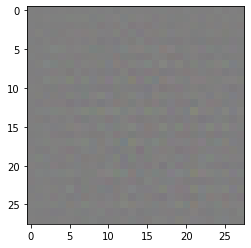

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [6]:
def scale_and_show(img):
  plt.imshow((img+1)/2)

generator = make_generator_model()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)
print(generated_image)

scale_and_show(generated_image[0])
plt.show()

print(generator.summary())

### The Discriminator

The discriminator is a CNN-based image classifier.

### Exercise 3 ✍️
The code below sets up the architecture of the discrimnator. Fill in the blanks with the correct input and output

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 3])) #what size is the input to the discriminator?
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1)) #how many outputs does the discriminator have?

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

We can also summarize the discriminator's structure. Does it match what you expected?

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)
print()
print (discriminator.summary())

tf.Tensor([[0.00419596]], shape=(1, 1), dtype=float32)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
________________________________________________________________

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
# This method returns a helper function to compute cross entropy loss.
# Cross entropy loss computes how similar one 0-1 array is to another.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

###Exercise 4 ✍️
**Discriminator Loss**

We need to quantify how well the discriminator distinguishes real images from fake. If the discriminator worked perfectly:
*    its predictions on real images would be the same as an array of 1s of the right shape
*   its predictions on fake (generated) images would be the same as an array of 0s of the right shape. 

We quantify the loss by making these two comparisons, then adding the real and fake loss. Complete the code below.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

**Generator loss**

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Fill in the code below, similar to calculating the discriminator loss:

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

## Train the model
We wil train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated images will look increasingly real. After about 50 epochs, they resemble faces. This may take about one minute / epoch with the default settings on Colab.

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      #Make images:
      generated_images = generator(noise, training=True)

      #Get the discriminator's output:
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      #Calculate each network's loss:
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    #Update each network's weights to (hopefully) reduce the loss next time:
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

We will periodically save checkpoints as we train. You can use them to restore your trained model if it gets interrupted for any reason.

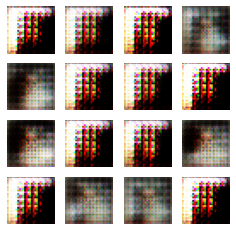

Time for epoch 18 is 6.818768501281738 sec


In [ ]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
train(train_dataset, EPOCHS)

To restore the latest checkpoint:

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


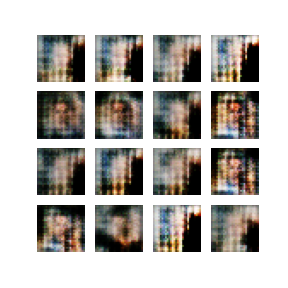

In [ ]:
#Run this to display example images from a specific epoch of training.
display_image(48)

In [ ]:
#@title Run this to download a GIF of your model's training.

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Conclusion 

Congratulations - you've generated faces that do not exist!

Our goal was to produce diverse faces that we could train to use face recognition systems. 

**Have we accomplished this goal? If not, why not, and what could we do to fix it?**

###Optional: Exercise 5 ✍️
The results so far are small and blurry. To get photo-realistic results that we can use to trian our image classifier, we need a bigger and more complex network and carefully chosen hyperparameters (and maybe a [few more tricks up our sleeve](https://github.com/NVlabs/stylegan).) Experiment with changing your model's architecture to produce bigger and better images.

It's notoriously difficult to choose good architectures and hyperparameters for a GAN - you may need a lot of trial and error!

In [ ]:
#@title License Information 
# Modified from https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors, which is
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.